# LBA Input Data Validation

This notebook validates MONC LBA data before running CloudTracker.

**Checks performed:**
1. Grid dimensions and coordinates
2. Reference profile reconstruction (θ_ref, p_ref)
3. Thermodynamic fields (θ, θ_l, pressure)
4. Wind fields (u, v, w)
5. Water species (vapor, liquid, ice, rain, etc.)

In [77]:
import sys
import os
import glob
from pathlib import Path

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset

# Add cloudtracker to path
sys.path.insert(0, str(Path.cwd().parent.parent))

from src.config_parsers.mcf_parser import MONCConfigParser
from src.adapters.monc_adapter import MONCAdapter

## 1. Configuration

Set paths to your MONC data and configuration file.

In [78]:
# === USER CONFIGURATION ===
DATA_PATH = '/Users/jure/PhD/coding/LBA_sample_data/jun10'
CONFIG_FILE = '/Users/jure/PhD/coding/LBA_sample_data/jun10/lba_config.mcf'
FILE_PATTERN = '3dfields_ts_{time}.nc'

## 2. Parse MONC Configuration

In [79]:
# Parse the .mcf configuration file
mcf = MONCConfigParser(CONFIG_FILE)
config = mcf.parse()

print("=" * 60)
print("MONC CONFIGURATION")
print("=" * 60)

# Grid configuration
print(f"\nGrid dimensions:")
print(f"  x_size = {config.get('x_size')}")
print(f"  y_size = {config.get('y_size')}")
print(f"  z_size = {config.get('z_size')}")

dx, dy = mcf.get_grid_spacing()
print(f"\nGrid spacing:")
print(f"  dx = {dx} m")
print(f"  dy = {dy} m")

p_surf, p_ref = mcf.get_surface_pressures()
print(f"\nPressure configuration:")
print(f"  surface_pressure = {p_surf} Pa")
print(f"  reference_pressure (p0) = {p_ref} Pa")

z_thref, f_thref = mcf.get_reference_theta_profile()
print(f"\nReference theta profile:")
print(f"  {len(z_thref)} points")
print(f"  z range: [{z_thref.min():.0f}, {z_thref.max():.0f}] m")
print(f"  θ range: [{f_thref.min():.1f}, {f_thref.max():.1f}] K")

MONC CONFIGURATION

Grid dimensions:
  x_size = 256
  y_size = 256
  z_size = 211

Grid spacing:
  dx = 200.0 m
  dy = 200.0 m

Pressure configuration:
  surface_pressure = 99130.0 Pa
  reference_pressure (p0) = 100000.0 Pa

Reference theta profile:
  47 points
  z range: [0, 29870] m
  θ range: [297.6, 762.4] K


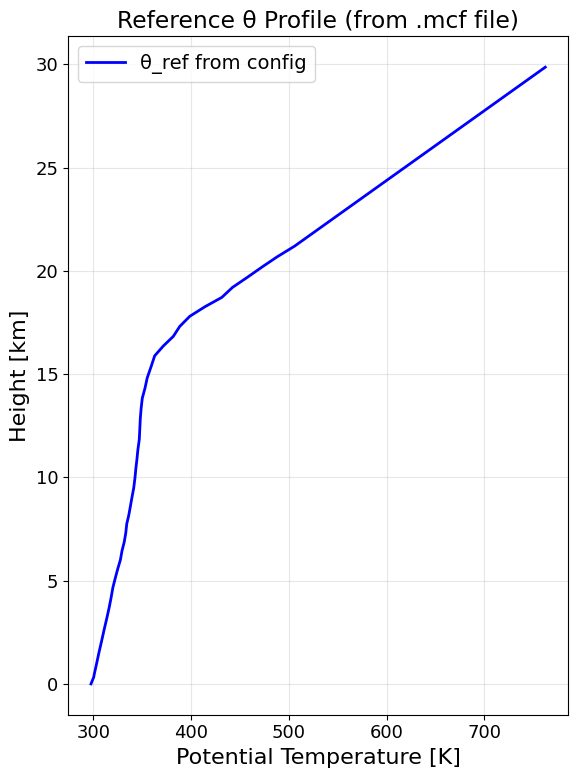

In [80]:
# Plot reference theta profile from config
fig, ax = plt.subplots(figsize=(6, 8))
ax.plot(f_thref, z_thref / 1000, 'b-', linewidth=2, label='θ_ref from config')
ax.set_xlabel('Potential Temperature [K]')
ax.set_ylabel('Height [km]')
ax.set_title('Reference θ Profile (from .mcf file)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

## 3. Initialize MONC Adapter and Check Grid

In [81]:
# Create adapter configuration
adapter_config = {
    'data_format': 'MONC',
    'monc_data_path': DATA_PATH,
    'monc_config_file': CONFIG_FILE,
    'monc_file_pattern': FILE_PATTERN,
}

# Initialize adapter
adapter = MONCAdapter(adapter_config)

# Get grid info
grid = adapter.get_grid_info()

print("=" * 60)
print("GRID VALIDATION")
print("=" * 60)
print(f"\nGrid from NetCDF:")
print(f"  nx = {grid['nx']}, ny = {grid['ny']}, nz = {grid['nz']}")
print(f"  dx = {grid['dx']} m, dy = {grid['dy']} m")

# Vertical grid analysis
zt = grid['zt']
dz = grid['dz']
print(f"\nVertical grid (scalar levels zn):")
print(f"  Height range: [{zt.min():.1f}, {zt.max():.1f}] m")
print(f"  dz: min={dz.min():.1f}, median={np.median(dz):.1f}, max={dz.max():.1f} m")

# Check for grid stretching
print(f"\nVertical grid stretching:")
print(f"  First 5 dz: {dz[:5].round(1)}")
print(f"  Last 5 dz: {dz[-5:].round(1)}")

Parsing MONC config: /Users/jure/PhD/coding/LBA_sample_data/jun10/lba_config.mcf
  dx=200.0m, dy=200.0m
  p_surface=99130.0 Pa, p0=100000.0 Pa
  Reference theta profile: 47 points, z=[0, 29870] m
  Found 21 MONC output files
  Time range: [7200, 10800] seconds
  Reference profiles computed:
    thref range: [297.6, 556.1] K
    pref range: [3138, 99130] Pa
GRID VALIDATION

Grid from NetCDF:
  nx = 256, ny = 256, nz = 211
  dx = 200.0 m, dy = 200.0 m

Vertical grid (scalar levels zn):
  Height range: [-25.0, 22900.0] m
  dz: min=50.0, median=100.0, max=200.0 m

Vertical grid stretching:
  First 5 dz: [50. 50. 50. 50. 50.]
  Last 5 dz: [200. 200. 200. 200. 200.]


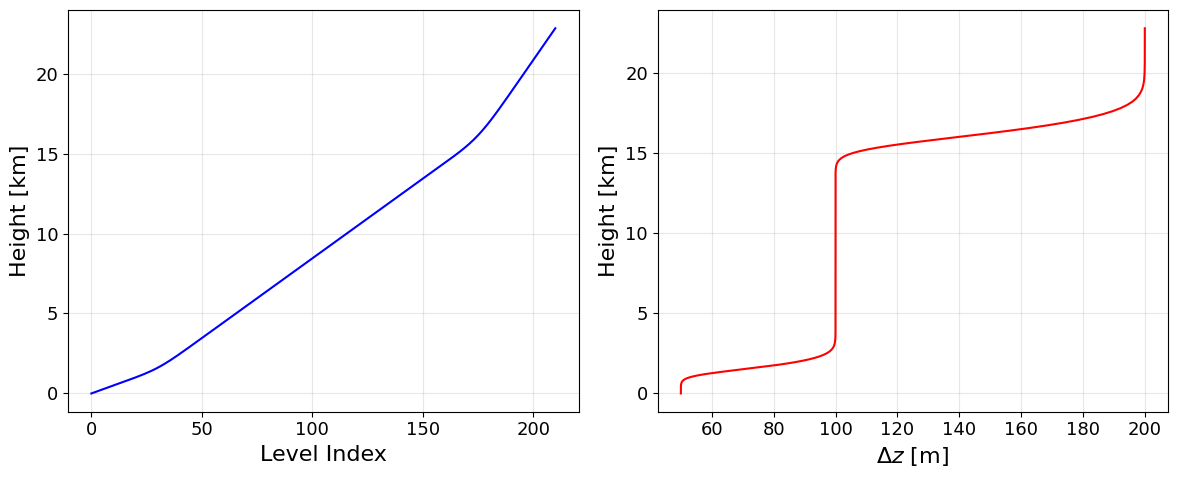

In [82]:
# Plot vertical grid spacing
plt.rcParams.update({'font.size': 14, 'axes.labelsize': 16, 'xtick.labelsize': 13, 'ytick.labelsize': 13})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Height vs level index
ax1.plot(range(len(zt)), zt / 1000, 'b-')
ax1.set_xlabel('Level Index')
ax1.set_ylabel('Height [km]')
ax1.grid(True, alpha=0.3)

# dz vs height
z_mid = 0.5 * (zt[:-1] + zt[1:])
ax2.plot(dz, z_mid / 1000, 'r-')
ax2.set_xlabel('$\Delta z$ [m]')
ax2.set_ylabel('Height [km]')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vertical_grid_spacing.pdf', bbox_inches='tight')
plt.show()

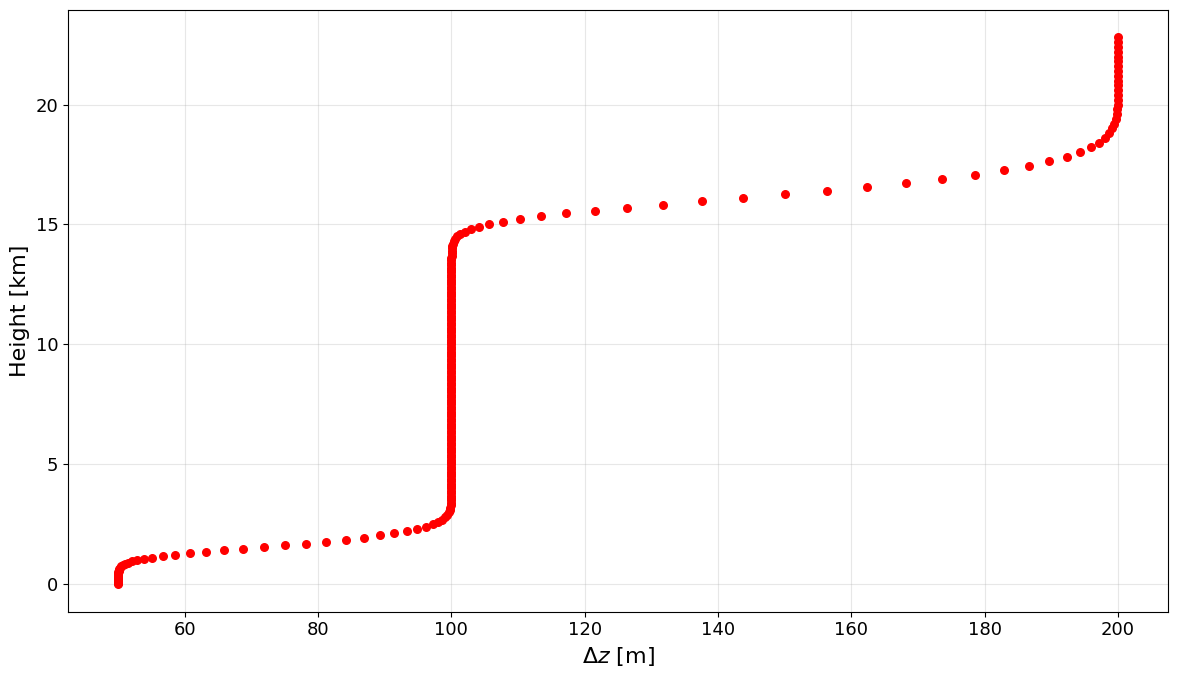

In [ ]:
plt.rcParams.update({'font.size': 14, 'axes.labelsize': 16, 'xtick.labelsize': 13, 'ytick.labelsize': 13})

fig, ax = plt.subplots(figsize=(12, 5))

z_mid = 0.5 * (zt[:-1] + zt[1:])
ax.scatter(dz, z_mid / 1000, s=30, color='r', zorder=3)
#ax.plot(dz, z_mid / 1000, 'r-', alpha=0.5)
ax.set_xlabel('$\Delta z$ [m]')
ax.set_ylabel('Height [km]')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vertical_grid_spacing_dz.pdf', bbox_inches='tight')
plt.show()

## 4. Reference Profile Validation

Check that the reference profiles (θ_ref, p_ref) computed by the adapter are physically reasonable.

In [84]:
# Get reference profiles from adapter
ref = adapter.get_reference_profiles()
z_ref = ref['z']
thref = ref['thref']
pref = ref['pref']

print("=" * 60)
print("REFERENCE PROFILE VALIDATION")
print("=" * 60)

print(f"\nθ_ref (interpolated to model grid):")
print(f"  Range: [{thref.min():.1f}, {thref.max():.1f}] K")
print(f"  Surface (z≈0): {thref[np.argmin(np.abs(z_ref))]:.1f} K")

print(f"\np_ref (hydrostatic):")
print(f"  Range: [{pref.min():.0f}, {pref.max():.0f}] Pa")
print(f"  Surface: {pref[np.argmin(np.abs(z_ref))]:.0f} Pa")
print(f"  At 5 km: {pref[np.argmin(np.abs(z_ref - 5000))]:.0f} Pa")
print(f"  At 10 km: {pref[np.argmin(np.abs(z_ref - 10000))]:.0f} Pa")

REFERENCE PROFILE VALIDATION

θ_ref (interpolated to model grid):
  Range: [297.6, 556.1] K
  Surface (z≈0): 297.6 K

p_ref (hydrostatic):
  Range: [3138, 99130] Pa
  Surface: 98560 Pa
  At 5 km: 54754 Pa
  At 10 km: 27930 Pa


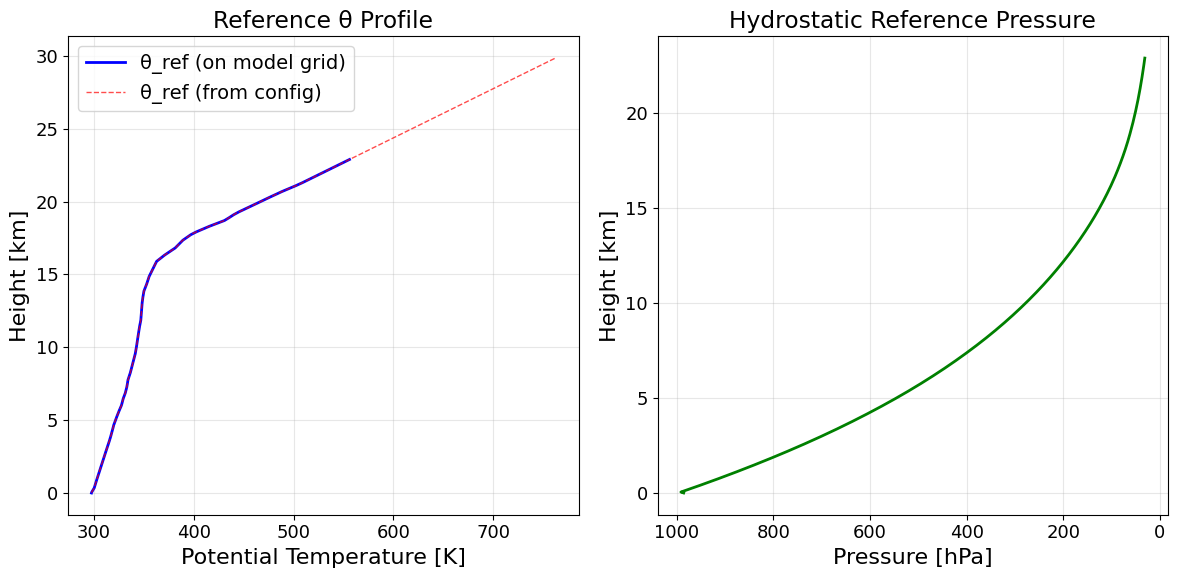

In [85]:
# Plot reference profiles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# θ_ref profile
ax1.plot(thref, z_ref / 1000, 'b-', linewidth=2, label='θ_ref (on model grid)')
ax1.plot(f_thref, z_thref / 1000, 'r--', linewidth=1, alpha=0.7, label='θ_ref (from config)')
ax1.set_xlabel('Potential Temperature [K]')
ax1.set_ylabel('Height [km]')
ax1.set_title('Reference θ Profile')
ax1.legend()
ax1.grid(True, alpha=0.3)

# p_ref profile
ax2.plot(pref / 100, z_ref / 1000, 'g-', linewidth=2)
ax2.set_xlabel('Pressure [hPa]')
ax2.set_ylabel('Height [km]')
ax2.set_title('Hydrostatic Reference Pressure')
ax2.grid(True, alpha=0.3)
ax2.invert_xaxis()  # Pressure decreases with height

plt.tight_layout()
plt.show()

## 5. Load Sample Timestep and Validate Fields

In [86]:
# Available timesteps
n_timesteps = adapter.get_total_timesteps()
times = adapter.get_timestep_times()

print(f"Available timesteps: {n_timesteps}")
print(f"Time range: [{times.min():.0f}, {times.max():.0f}] seconds")
print(f"            [{times.min()/60:.1f}, {times.max()/60:.1f}] minutes")

if n_timesteps > 1:
    dt = np.diff(times)
    print(f"Time interval: {dt[0]:.0f} seconds ({dt[0]/60:.1f} minutes)")

Available timesteps: 21
Time range: [7200, 10800] seconds
            [120.0, 180.0] minutes
Time interval: 180 seconds (3.0 minutes)


In [87]:
# Load first timestep
timestep_idx = 0
print(f"\nLoading timestep {timestep_idx} (t = {times[timestep_idx]/60:.1f} min)...")
data = adapter.load_timestep(timestep_idx)

print("\n" + "=" * 60)
print("FIELD SUMMARY")
print("=" * 60)

for key, value in data.items():
    if isinstance(value, np.ndarray):
        if value.ndim == 3:
            print(f"{key:10s}: shape={str(value.shape):18s} range=[{value.min():.6g}, {value.max():.6g}]")
        elif value.ndim == 1:
            print(f"{key:10s}: shape={str(value.shape):18s} range=[{value.min():.2f}, {value.max():.2f}]")


Loading timestep 0 (t = 120.0 min)...
Loading MONC data: 3dfields_ts_7200.nc (t=7200.0s)

FIELD SUMMARY
l         : shape=(211, 256, 256)    range=[0, 0]
u         : shape=(211, 256, 256)    range=[-17.5553, 3.10412]
v         : shape=(211, 256, 256)    range=[-6.68263, 13.0763]
w         : shape=(211, 256, 256)    range=[-0.520754, 0.602786]
p         : shape=(211, 256, 256)    range=[3503.86, 99130.8]
theta_l   : shape=(211, 256, 256)    range=[300.742, 556.12]
q_t       : shape=(211, 256, 256)    range=[0, 0.0292884]
r         : shape=(211, 256, 256)    range=[0, 0]
xt        : shape=(256,)             range=[100.00, 51100.00]
yt        : shape=(256,)             range=[100.00, 51100.00]
zt        : shape=(211,)             range=[-25.00, 22900.00]


## 6. Thermodynamic Field Validation

In [88]:
theta_l = data['theta_l']
p = data['p']
zt = data['zt']

print("=" * 60)
print("THERMODYNAMIC FIELD VALIDATION")
print("=" * 60)

# θ_l statistics
print(f"\nθ_l (liquid water potential temperature):")
print(f"  Global range: [{theta_l.min():.1f}, {theta_l.max():.1f}] K")
print(f"  Domain mean at surface: {theta_l[1, :, :].mean():.1f} K")
print(f"  Domain mean at 5 km: {theta_l[np.argmin(np.abs(zt - 5000)), :, :].mean():.1f} K")

# Check θ_l is reasonable (should be ~280-600 K in troposphere)
if theta_l.min() < 200 or theta_l.max() > 700:
    print(f"  ⚠ WARNING: θ_l values outside typical range!")
else:
    print(f"  ✓ θ_l values within expected range")

# Pressure statistics
print(f"\nPressure:")
print(f"  Global range: [{p.min():.0f}, {p.max():.0f}] Pa")
print(f"  Surface: {p[1, 128, 128]:.0f} Pa ({p[1, 128, 128]/100:.0f} hPa)")

if p.max() < 50000 or p.max() > 110000:
    print(f"  ⚠ WARNING: Surface pressure outside typical range!")
else:
    print(f"  ✓ Pressure values within expected range")

THERMODYNAMIC FIELD VALIDATION

θ_l (liquid water potential temperature):
  Global range: [300.7, 556.1] K
  Domain mean at surface: 301.4 K
  Domain mean at 5 km: 321.5 K
  ✓ θ_l values within expected range

Pressure:
  Global range: [3504, 99131] Pa
  Surface: 99130 Pa (991 hPa)
  ✓ Pressure values within expected range


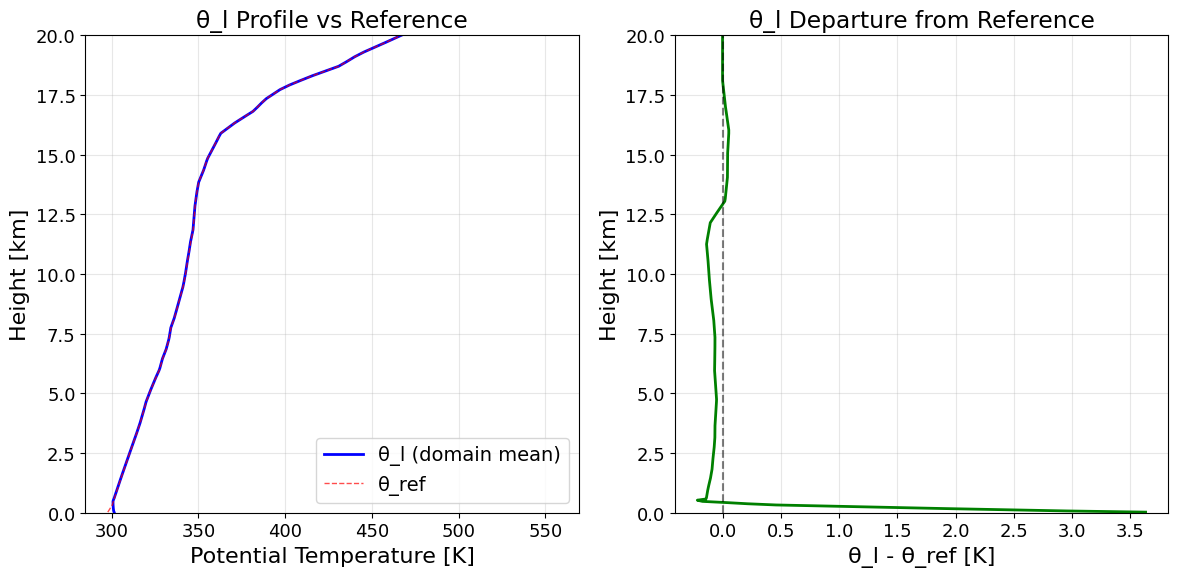

In [89]:
# Plot θ_l profiles (excluding ghost level below surface)
# zt[0] < 0 is a sub-surface ghost level for boundary conditions
phys_mask = zt >= 0  # Physical atmospheric levels only

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Domain-mean θ_l profile (physical levels only)
theta_l_mean = theta_l[phys_mask, :, :].mean(axis=(1, 2))
zt_phys = zt[phys_mask]
thref_phys = thref[phys_mask]

ax1.plot(theta_l_mean, zt_phys / 1000, 'b-', linewidth=2, label='θ_l (domain mean)')
ax1.plot(thref_phys, zt_phys / 1000, 'r--', linewidth=1, alpha=0.7, label='θ_ref')
ax1.set_xlabel('Potential Temperature [K]')
ax1.set_ylabel('Height [km]')
ax1.set_title('θ_l Profile vs Reference')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 20])

# θ_l - θ_ref difference (physical levels only)
theta_l_diff = theta_l_mean - thref_phys
ax2.plot(theta_l_diff, zt_phys / 1000, 'g-', linewidth=2)
ax2.axvline(0, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('θ_l - θ_ref [K]')
ax2.set_ylabel('Height [km]')
ax2.set_title('θ_l Departure from Reference')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 20])

plt.tight_layout()
plt.show()

## 7. Wind Field Validation

In [90]:
u = data['u']
v = data['v']
w = data['w']

print("=" * 60)
print("WIND FIELD VALIDATION")
print("=" * 60)

print(f"\nU (zonal wind):")
print(f"  Range: [{u.min():.2f}, {u.max():.2f}] m/s")
print(f"  Domain mean: {u.mean():.2f} m/s")

print(f"\nV (meridional wind):")
print(f"  Range: [{v.min():.2f}, {v.max():.2f}] m/s")
print(f"  Domain mean: {v.mean():.2f} m/s")

print(f"\nW (vertical velocity):")
print(f"  Range: [{w.min():.2f}, {w.max():.2f}] m/s")
print(f"  Domain mean: {w.mean():.4f} m/s")
print(f"  Max updraft: {w.max():.2f} m/s")
print(f"  Max downdraft: {w.min():.2f} m/s")

# Check w is reasonable
if np.abs(w.mean()) > 0.1:
    print(f"  ⚠ WARNING: Domain-mean w is not near zero!")
else:
    print(f"  ✓ Domain-mean w ≈ 0 as expected")

WIND FIELD VALIDATION

U (zonal wind):
  Range: [-17.56, 3.10] m/s
  Domain mean: -3.66 m/s

V (meridional wind):
  Range: [-6.68, 13.08] m/s
  Domain mean: 2.00 m/s

W (vertical velocity):
  Range: [-0.52, 0.60] m/s
  Domain mean: -0.0000 m/s
  Max updraft: 0.60 m/s
  Max downdraft: -0.52 m/s
  ✓ Domain-mean w ≈ 0 as expected


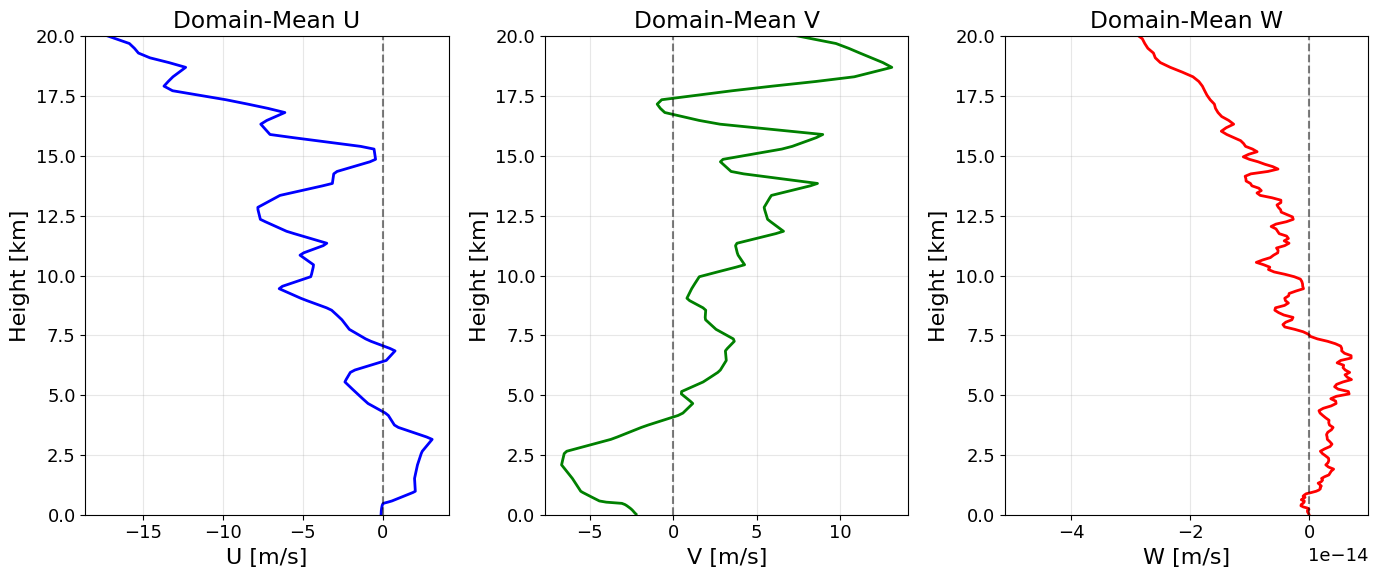

In [91]:
# Plot wind profiles (excluding ghost level below surface)
phys_mask = zt >= 0  # Physical atmospheric levels only
zt_phys = zt[phys_mask]

fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# Domain-mean profiles (physical levels only)
u_mean = u[phys_mask, :, :].mean(axis=(1, 2))
v_mean = v[phys_mask, :, :].mean(axis=(1, 2))
w_mean = w[phys_mask, :, :].mean(axis=(1, 2))

axes[0].plot(u_mean, zt_phys / 1000, 'b-', linewidth=2)
axes[0].axvline(0, color='k', linestyle='--', alpha=0.5)
axes[0].set_xlabel('U [m/s]')
axes[0].set_ylabel('Height [km]')
axes[0].set_title('Domain-Mean U')
axes[0].grid(True, alpha=0.3)

axes[1].plot(v_mean, zt_phys / 1000, 'g-', linewidth=2)
axes[1].axvline(0, color='k', linestyle='--', alpha=0.5)
axes[1].set_xlabel('V [m/s]')
axes[1].set_ylabel('Height [km]')
axes[1].set_title('Domain-Mean V')
axes[1].grid(True, alpha=0.3)

axes[2].plot(w_mean, zt_phys / 1000, 'r-', linewidth=2)
axes[2].axvline(0, color='k', linestyle='--', alpha=0.5)
axes[2].set_xlabel('W [m/s]')
axes[2].set_ylabel('Height [km]')
axes[2].set_title('Domain-Mean W')
axes[2].grid(True, alpha=0.3)

for ax in axes:
    ax.set_ylim([0, 20])

plt.tight_layout()
plt.show()

## 8. Water Species Validation

In [92]:
l = data['l']      # cloud liquid water
q_t = data['q_t']  # total water (vapor + cloud + ice)
r = data['r']      # rain

print("=" * 60)
print("WATER SPECIES VALIDATION")
print("=" * 60)

print(f"\nCloud liquid water (l):")
print(f"  Range: [{l.min():.6g}, {l.max():.6g}] kg/kg")
print(f"  Max: {l.max() * 1000:.3f} g/kg")
cloudy_points = np.sum(l > 1e-5)
total_points = l.size
print(f"  Cloudy points (l > 1e-5): {cloudy_points} ({100*cloudy_points/total_points:.2f}%)")

print(f"\nTotal water (q_t):")
print(f"  Range: [{q_t.min():.6g}, {q_t.max():.6g}] kg/kg")
print(f"  Surface mean: {q_t[1, :, :].mean() * 1000:.2f} g/kg")

print(f"\nRain (r):")
print(f"  Range: [{r.min():.6g}, {r.max():.6g}] kg/kg")
print(f"  Max: {r.max() * 1000:.3f} g/kg")

# Unit check
if q_t.max() > 0.1:
    print(f"\n⚠ WARNING: q_t max > 0.1 - units might be g/kg instead of kg/kg!")
else:
    print(f"\n✓ Water species appear to be in kg/kg")

WATER SPECIES VALIDATION

Cloud liquid water (l):
  Range: [0, 0] kg/kg
  Max: 0.000 g/kg
  Cloudy points (l > 1e-5): 0 (0.00%)

Total water (q_t):
  Range: [0, 0.0292884] kg/kg
  Surface mean: 17.14 g/kg

Rain (r):
  Range: [0, 0] kg/kg
  Max: 0.000 g/kg

✓ Water species appear to be in kg/kg


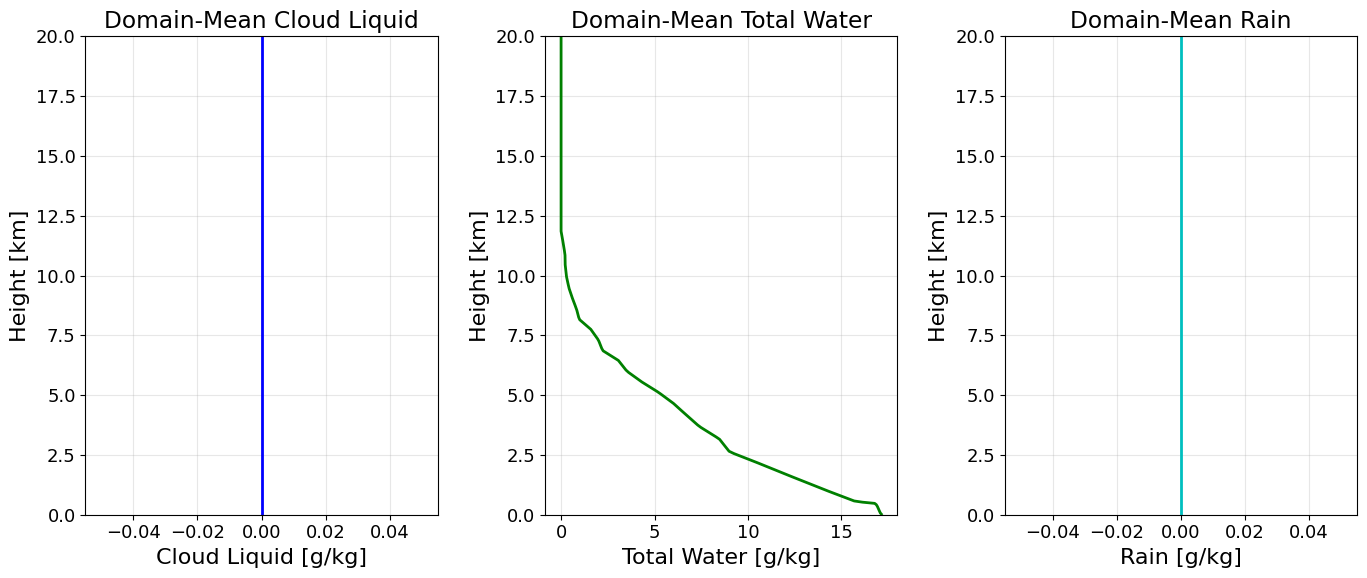

In [93]:
# Plot water profiles (excluding ghost level below surface)
phys_mask = zt >= 0  # Physical atmospheric levels only
zt_phys = zt[phys_mask]

fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# Domain-mean profiles (convert to g/kg for plotting, physical levels only)
l_mean = l[phys_mask, :, :].mean(axis=(1, 2)) * 1000
q_t_mean = q_t[phys_mask, :, :].mean(axis=(1, 2)) * 1000
r_mean = r[phys_mask, :, :].mean(axis=(1, 2)) * 1000

axes[0].plot(l_mean, zt_phys / 1000, 'b-', linewidth=2)
axes[0].set_xlabel('Cloud Liquid [g/kg]')
axes[0].set_ylabel('Height [km]')
axes[0].set_title('Domain-Mean Cloud Liquid')
axes[0].grid(True, alpha=0.3)

axes[1].plot(q_t_mean, zt_phys / 1000, 'g-', linewidth=2)
axes[1].set_xlabel('Total Water [g/kg]')
axes[1].set_ylabel('Height [km]')
axes[1].set_title('Domain-Mean Total Water')
axes[1].grid(True, alpha=0.3)

axes[2].plot(r_mean, zt_phys / 1000, 'c-', linewidth=2)
axes[2].set_xlabel('Rain [g/kg]')
axes[2].set_ylabel('Height [km]')
axes[2].set_title('Domain-Mean Rain')
axes[2].grid(True, alpha=0.3)

for ax in axes:
    ax.set_ylim([0, 20])

plt.tight_layout()
plt.show()

## 9. Horizontal Slice Visualization

Level with maximum cloud liquid: level 0 (z = -25 m)
Timestep: 0 (t = 120.0 min)


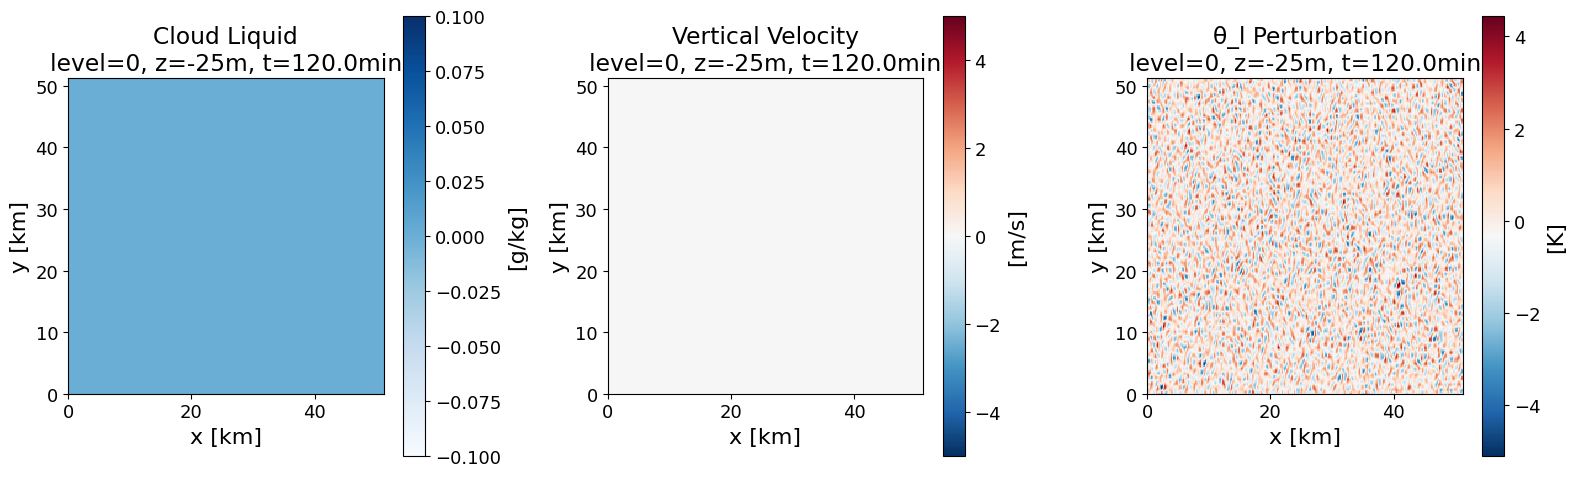

In [94]:
# Find a level with clouds
l_by_level = l.max(axis=(1, 2))
cloud_level = np.argmax(l_by_level)
cloud_height = zt[cloud_level]
time_min = times[timestep_idx] / 60

print(f"Level with maximum cloud liquid: level {cloud_level} (z = {cloud_height:.0f} m)")
print(f"Timestep: {timestep_idx} (t = {time_min:.1f} min)")

# Plot horizontal slices
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

xt = data['xt'] / 1000  # km
yt = data['yt'] / 1000  # km

# Cloud liquid
im0 = axes[0].pcolormesh(xt, yt, l[cloud_level, :, :] * 1000, cmap='Blues', shading='auto')
axes[0].set_title(f'Cloud Liquid\nlevel={cloud_level}, z={cloud_height:.0f}m, t={time_min:.1f}min')
axes[0].set_xlabel('x [km]')
axes[0].set_ylabel('y [km]')
plt.colorbar(im0, ax=axes[0], label='[g/kg]')

# Vertical velocity
im1 = axes[1].pcolormesh(xt, yt, w[cloud_level, :, :], cmap='RdBu_r', shading='auto',
                          vmin=-5, vmax=5)
axes[1].set_title(f'Vertical Velocity\nlevel={cloud_level}, z={cloud_height:.0f}m, t={time_min:.1f}min')
axes[1].set_xlabel('x [km]')
axes[1].set_ylabel('y [km]')
plt.colorbar(im1, ax=axes[1], label='[m/s]')

# θ_l perturbation
theta_l_pert = theta_l[cloud_level, :, :] - theta_l[cloud_level, :, :].mean()
im2 = axes[2].pcolormesh(xt, yt, theta_l_pert, cmap='RdBu_r', shading='auto')
axes[2].set_title(f'θ_l Perturbation\nlevel={cloud_level}, z={cloud_height:.0f}m, t={time_min:.1f}min')
axes[2].set_xlabel('x [km]')
axes[2].set_ylabel('y [km]')
plt.colorbar(im2, ax=axes[2], label='[K]')

for ax in axes:
    ax.set_aspect('equal')


plt.tight_layout()
plt.show()

## 10. Validation Summary

In [95]:
print("=" * 60)
print("VALIDATION SUMMARY")
print("=" * 60)

checks = []

# Grid checks
checks.append(('Grid dimensions match config', 
               grid['nx'] == config.get('x_size') and grid['ny'] == config.get('y_size')))

# θ_l range
checks.append(('θ_l in reasonable range (200-700 K)', 
               theta_l.min() > 200 and theta_l.max() < 700))

# Pressure range
checks.append(('Pressure in reasonable range', 
               p.min() > 1000 and p.max() < 110000))

# Water units
checks.append(('Water species in kg/kg', q_t.max() < 0.1))

# Domain-mean w
checks.append(('Domain-mean w ≈ 0', np.abs(w.mean()) < 0.1))

# Clouds present
checks.append(('Clouds detected (l > 1e-5)', np.any(l > 1e-5)))

print("\nCheck Results:")
all_passed = True
for name, passed in checks:
    status = '✓' if passed else '✗'
    print(f"  {status} {name}")
    if not passed:
        all_passed = False

print("\n" + "=" * 60)
if all_passed:
    print("All checks PASSED - Data ready for CloudTracker")
else:
    print("Some checks FAILED - Review warnings above")
print("=" * 60)

VALIDATION SUMMARY

Check Results:
  ✓ Grid dimensions match config
  ✓ θ_l in reasonable range (200-700 K)
  ✓ Pressure in reasonable range
  ✓ Water species in kg/kg
  ✓ Domain-mean w ≈ 0
  ✗ Clouds detected (l > 1e-5)

Some checks FAILED - Review warnings above
